# Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('Telco-Customer-Churn.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)
df.churn = (df.churn == 'yes').astype(int)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [c for c in list(df.columns) if c not in numerical + ['customerid', 'churn']]

dicts_train = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)
y_train = df_train.churn.values
model = LogisticRegression()
model.fit(X_train, y_train)

dicts_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dicts_val)
y_val = df_val.churn
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(churn_decision == y_val).mean()


/Users/kasteion/repos/kasteion/machine-learning-zoomcamp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.8034066713981547)

## Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [2]:
# How many customers we have in the validation dataset
len(df_val)

1409

In [3]:
print("Correct:", (churn_decision == y_val).sum())

Correct: 1132


In [4]:
print("Accuracy:",  (churn_decision == y_val).sum() / len(df_val))

Accuracy: 0.8034066713981547


In [5]:
# Is the same as the mean
print("Accuracy:", (churn_decision == y_val).mean())

Accuracy: 0.8034066713981547


Threshold: 0.00 Score: 0.274
Threshold: 0.05 Score: 0.509
Threshold: 0.10 Score: 0.591
Threshold: 0.15 Score: 0.666
Threshold: 0.20 Score: 0.710
Threshold: 0.25 Score: 0.739
Threshold: 0.30 Score: 0.760
Threshold: 0.35 Score: 0.772
Threshold: 0.40 Score: 0.785
Threshold: 0.45 Score: 0.793
Threshold: 0.50 Score: 0.803
Threshold: 0.55 Score: 0.801
Threshold: 0.60 Score: 0.795
Threshold: 0.65 Score: 0.786
Threshold: 0.70 Score: 0.766
Threshold: 0.75 Score: 0.744
Threshold: 0.80 Score: 0.735
Threshold: 0.85 Score: 0.726
Threshold: 0.90 Score: 0.726
Threshold: 0.95 Score: 0.726
Threshold: 1.00 Score: 0.726


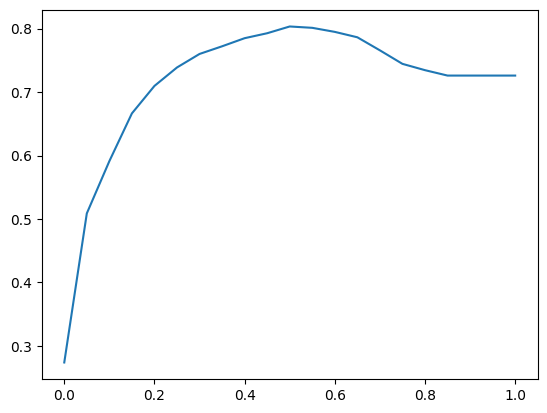

In [6]:
# We can measure the accuracy using different thresholds
# Here we are creating 21 thresholds between 0 and 1
thresholds = np.linspace(0, 1, 21)

scores = []

# And we can measure the accuracy for each threshold
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('Threshold: %.2f Score: %.3f' % (t, score))
    scores.append(score)

# We plot the scores
plt.plot(thresholds, scores)

In [7]:
# We measured the accuracy with this:
#   churn_decision = (y_pred >= t)
#   score = (y_val == churn_decision).mean()
# But we can use the accuracy_score function from sklearn.metrics
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [8]:
# And the accuracy of the thresholds will be like this:
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('Threshold: %.2f Score: %.3f' % (t, score))
    scores.append(score)

Threshold: 0.00 Score: 0.274
Threshold: 0.05 Score: 0.509
Threshold: 0.10 Score: 0.591
Threshold: 0.15 Score: 0.666
Threshold: 0.20 Score: 0.710
Threshold: 0.25 Score: 0.739
Threshold: 0.30 Score: 0.760
Threshold: 0.35 Score: 0.772
Threshold: 0.40 Score: 0.785
Threshold: 0.45 Score: 0.793
Threshold: 0.50 Score: 0.803
Threshold: 0.55 Score: 0.801
Threshold: 0.60 Score: 0.795
Threshold: 0.65 Score: 0.786
Threshold: 0.70 Score: 0.766
Threshold: 0.75 Score: 0.744
Threshold: 0.80 Score: 0.735
Threshold: 0.85 Score: 0.726
Threshold: 0.90 Score: 0.726
Threshold: 0.95 Score: 0.726
Threshold: 1.00 Score: 0.726


In [9]:
# The threshold of 1.0 is interesting because it is a model that predicts that nobody will churn
# And even if we have a model that predicts that no customers will churn it will have 72% accuracy
# The difference between a model that predicts nobody will churn an our model the difference is 7% (sort of)
# This is because we have class imbalance (to many people will not churn and little people will churn)
# We will look to the numbers that can help us evaluate our model better.
from collections import Counter
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

# Confusion table

- Different types of errors and correct decissions
    - True Negatives: Correct (Predicted no churn and didn't churn)
    - False Negatives: Error (Predicted no churn and churned)
    - False Positive: Error (Predicted churn and didn't churn)
    - True Positivie: Correct (Predicted churn and churned)
- Arranging them in a table

In [10]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [11]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
# True positives: 210 (Correct)
tp = (predict_positive & actual_positive).sum()
# True negatives: 910 (Correct)
tn = (predict_negative & actual_negative).sum()
# False positives: (Error)
fp = (predict_positive & actual_negative).sum()
# False negatives: (Error)
fn = (predict_negative & actual_positive).sum()

In [19]:
# A confussion matrix is a way to have the sum results (Correct and Errors) in the same matrix
# Is a table like this:
#               Predictions
#                     Negative       |   Positive    |
#           Negative  922 (65%)      | 101 (7%) (Err)
#   Actual            -------------- | ------------- |
#           Positive  176 (12%) (Err)| 210 (14%)
# 
# We can notice we have a lot more False Negatives than False Positives
#
# Here instead of having 1 value we have 4 values
# And from the values of the confussion matrix we can derive more metrics
confussion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confussion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
confussion_matrix / confussion_matrix.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

# Precision and Recall

Metrics to validate binary classification models based on the values of the confussion table.

In [24]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.8034066713981547)

**Precission**: Fraction of positive predictions that are correct

In [25]:
# Precission is 67% so we sent promotional email to 33% of users that weren't going to churn (They probably will take advantage of our promitional emails)
precission = tp / (tp + fp)
precission

np.float64(0.6752411575562701)

**Recall**: Fraction of correctly identified positive examples

In [27]:
# Recall is 54% so we failed to identify 46% of users that were going to churn
# true positives / (true positives + false negatives)
recall = tp / (tp + fn)
recall

np.float64(0.5440414507772021)

We notice our model is not as accurate as we thought (80%) this is because we have a class imbalance in the data provided.